# リバース量子アニーリングを用いたポートフォリオ最適化

## はじめに

この章ではポートフォリオ最適化問題を例として、OpenJijを用いてリバース量子アニーリング（Reverse Quantum Annealing）という、古典的な最適化計算と、量子アニーリングを組み合わせた手法を紹介します。このチュートリアルでは、古典的なアルゴリズム、普通の量子アニーリング、そしてリバース量子アニーリングそれぞれで同じポートフォリオ最適化問題を解き、その結果を比較します。またその過程を通して、OpenJijでの量子アニーリングの実装や実験を行う時の注意点についても触れていきます。

*注意：このポートフォリオの内容を正しく実行するにはOpenJij0.4.9以上が必要です。必要な場合は実行前に次のコマンドを実行し、OpenJijのアップデートを行なってください。*
```bash
pip install -U openjij
```

## ポートフォリオ最適化問題
  資産運用のための投資活動を行うとき、誰しも「できるだけリスクを回避しながら大きな収益を実現させたい」と考えるはずです。よって収益が限定的ですが、リスクが小さい（ないし全くない）資産と、見込める収益が大きい分リスクも大きい資産を組み合わせてポートフォリオを作り、分散投資を行うのが一般的な戦略となります。

  この時、与えられた一定のリスクでは最大利益を実現したい、または同じ利益を実現する場合にできるだけ小さいリスクを取るには、最適なポートフォリオを選ぶ必要があります。現在、よく利用される手法にMarkowitzによる現代ポートフォリオ理論(Modern Portfolio Theory)があります。ポートフォリオを構成する銘柄の間の相関を考慮し、その共分散を最小にすることを目指す手法です[1]。
  
  $$
  \min \sum_{i=1}^{N}\sum_{j=1}^{N}w_{i}w_{j}\sigma_{ij}; \quad \sum_{i=1}^{N}W_{i}=1; \quad \sum_{i=1}^{N}W_{i}\mu_{i}=R
  $$
  
  $w_{i}$は各銘柄がポートフォリオ内に占める重み、$\sigma_{ij}$は銘柄間の共分散を表します。$\mu_{i}$は各銘柄の期待収益で、$R$はこのポートフォリオの総収益です。

  この時、ポートフォリオのパフォーマンスの評価によく使われる指標としてSharpe Ratioというものがあります。

  ### Sharpe Ratio
  Sharpe Ratioは投資の効率性を評価する指標で、銘柄単体とポートフォリオに対して計算されます。1966年にウィリアム・シャープによって提案されました[3]。その基本的な定義を以下に示します。
  
  $$
  S = \frac{\bar{r}-r_0}{\sigma}
  $$
  
  ここで$\bar{r}$は一定時間内の平均的なリターン率で、月間や年間リターンの平均を利用することが多くあります。$r_0$はリスクなしの場合のリターン率を表し、普段は安定した国債の利子率などを用います。そして$\sigma$は資産価値の変動の激しさを意味するボラティリティです。
  
  実際にSharpe Ratioを計算するときには、場面によって異なる計算方法でこれらの値を算出します。例えばリターンは単純リターンとして$r=P(t+1)/P(t) - 1$で資産価格$P$を使って計算される場合と、$r=log[P(t+1)/P(t)]$のように対数リターン率として計算される場合が存在します。そしてボラティリティも価格の変動から計算する手法とリターン率からの計算するやり方があります。具体的に興味がある方は金融工学や市場分析などに関連する本とサイトに参照すると良いでしょう。


  ### ポートフォリオの評価と最適化
  Sharpe Ratioの定義から、その値が大きいということは収益が大きいまたはリスク（ボラティリティ）が小さいことを意味します。ある与えられた銘柄の集合から作られたポートフォリオのうち、最大のSharpe Ratioを実現できるような組合せは、単位リスクに対して最大のリターンを得る組み合わせと言えます。よってポートフォリオの最適化問題が一定の考え方の元では、Shape Ratioを最大化する問題に置き換えることができます。

  現実では、この最適化は銘柄を選別した上で、それぞれの銘柄に投入する資金の量を決定しなければなりません。すなわち、これは選ぶ銘柄と各銘柄のウェイトを決定する組合せ最適化問題となります。このチュートリアルは、参考にした論文[2]に従い、簡単のために各銘柄のウェイトを等しくする戦略について考えます。$M$個ある銘柄のうち$N$個銘柄を選び出し、Sharpe Ratioを最大にする組合せを求めます。すると、次のようなQUBO形式に問題を翻訳することができます。

  $$
  \mathcal{O}(\boldsymbol{q})=\sum_{i=1}^{N}a_{i}q_{i}+\sum_{i=1}^{N}\sum_{j=i+1}^{N}b_{ij}q_{i}q_{j}
  $$
  
  ここで$q_{i}$は各銘柄に対する選択を表すバイナリ変数で、$1$であればポートフォリオに組み入れ、$0$であれば組み入れないことを意味します。$a_i$は銘柄自体のパフォーマンスによる魅力スコアであり、$b_{ij}$は銘柄間のペアワイズ相関で決められた罰金または賞金の度合を表します。

  具体的に$a_i$と$b_{ij}$は次の表1に従って決定されます。

<img src="../../../assets/reverse_annealing_RQA_QUBO.png">


  この表の$a_i$のグループは、ポートフォリオを構成する人によって決められた基準であり、銘柄を魅力的であるものから順に並べられたものです。それらを順位付けした後に、均等に分けた場合に形成されたグループを示しています。この魅力的な基準はリターン率の高さなどの要素も取り入れられますが、このチュートリアルでは単純に銘柄単体のSharpe Ratio順を用いています。次の$b_{ij}$は対数リターンの時系列から求められた相関行列の成分$\rho_{ij}$の値によって決められたものです。

  このQUBOを用いて量子アニーリングを実行すれば、最適なポートフォリオを得ることができるはずです。また、選択銘柄の数について指定したい場合は、銘柄数に対して制約条件を付け加えます。ただし、参考にした論文[2]によると、制約条件を罰金法でQUBOに付け加えた場合、導入した大きい相互作用（ペナルティ）はアニーリング性能や最終的に取得した結果にも影響することが示されています。現実の問題では、最適なポートフォリオに含まれる銘柄の数は分からないため、このチュートリアルでも同様に銘柄数制限なしての最適化を行います。

## Reverse Quantum Annealingによるポートフォリオ最適化
現実のポートフォリオ最適化の問題は基本、大きな銘柄数を持つ市場からいくつかの銘柄を選択することになります。候補銘柄数が増加すると、最適なポートフォリオを作るための計算量も大きくなります。よって一定の条件の下に選別を行い、その次に最適化アルゴリズを適応するのが一般的です。そして、銘柄の組合せの自由度から、最終的に実現したSharpe Ratioが最大Sharpe Ratioと極めて近い値を持つような局所解が多く存在することもあり得ます。伝統的なアルゴリズムがそのようなエネルギーランドスケープの谷に囚われた場合、そこから抜け出すのにも時間とリソースが必要となります。そのため、以上の既存の問題点を回避しつつポートフォリオ最適化問題を解くには、量子アニーリングのような大きい数の相関を取り扱うことができ、かつ局所解から脱却できる計算手法の方が上手に解くことができます。

ただし参考論文[2]に示されたように、単純なForward Annealingのみを行う場合では、銘柄数の増加により、最適解までにたどり着く時間も大きく増加します。結果としてこれまでの遺伝的アルゴリズムと近いパフォーマンスになることが判明しています。その理由としては先述の通り、最適解と近い値のSharpe Ratioを持つ解と最適解はエネルギーの違いが小さく、最適解へのエネルギー変化がほぼない準位間に高いポテンシャル障壁があるような遷移となるため、遷移が起こるまでにより長い時間が必要となるためでし。また量子アニーリングマシン実機では、通常のアニーリングを行う途中で熱ノイズなどにより系が励起されて時間発展する場合があります。これらの要因により、最終結果が最適解とならないこともあります。


### Reverse Quantum Annealing
これら量子アニーリングを用いた時の問題点を解決するために提案された手法の一つに、Reverse Quantum Annealingがあります。名前通り、通常のForward Annealingと逆方向のステップを導入するような量子アニーリングを実行することを意味します。通常のForward Annealingの時間依存のハミルトニアンは次のように書かれます。

$$
\mathcal{H}_{\mathrm{QA}}(t)=A[t]\sum_{i=1}^N\sigma_{i}^{\mathrm{x}}+B[t]\mathcal{H}_{\chi-\mathrm{Ising}}
$$

ここで$A[t]$はアニーリングを行うとき系にかける横磁場の大きさ、$B[t]$は問題のハミルトニアン$\mathcal{H}_{\chi-\mathrm{Ising}}$の振幅を表します。次の図でのa)で示されるように、Forward Annealingの場合はアニーリングの進行に従って、$A[t]$を徐々に小さくし、同時に$B[t]$を支配的にさせていきます。アニーリング完了時では$A[t]=0$となります。

<img src="../../../assets/reverse_annealing_QAandRQA.png">

それに対し、Reverse Annealingはb)のように$A[t]=0,B[t]=1$の状態から出発します。このとき、まず通常とは逆に$B[t]$を小さくしていきます。これをReverse Phaseと呼びます。この段階では系のエネルギーが逆に高くなるため、c)に示されているようなAB間のポテンシャル障壁を越えやすくなります。そして$A[t], B[t]$をある値に到達させた後、系をそのままの状態を維持してしばらく待ちます。これをPause Phaseと呼びます。この間も高いエネルギーの状態が維持されるため、熱的ホッピングが起こりやすい状況となります。するとBの右側のようなポテンシャル障壁も越えやすくなっています。これにより最初にいた局所解から脱し、最適解付近にたどり着く可能性が上がることが示唆されます。最後にまた$A[t]$を小さくし、$B[t]$を大きくさせるForward Phaseで通常のアニーリングを実行することで、最適解を取得します。このプロトコルでは、Reverse phadeで$A[t], B[t]$を停止させた値や、各段階での継続時間などにより、最終的に得られる解のパフォーマンスにも影響することが考えられます。

### Reverse Quantum Annealingによるポートフォリオ最適化の手順
ここまでの議論から、Reverse annealingではReverse Phaseの初期状態が必要です。ランダムに生成された初期状態を用いることも可能ですが、手法が提案された背景からもわかるように、ある種の局所解の状態を用意したほうが最適解探索の効率が向上することが予想されます。参考論文[2]では初期状態となる局所解を得るために、伝統的なアルゴリズムで得られた出力を利用しています。このチュートリアルもそれに従って、Revearse annealingを実行してみましょう。

以上から、これから行う実装は基本論文[2]の流れを参考にして以下のようになります。
- 最適化を行う銘柄データの生成
- 古典なアルゴリズムの実装とその結果の確認
- 通常のForward Annealingによる最適解探索
- Reverse Quantum Annealingによる最適解探索
- Reverse Quantum Annealingのパラメータ探索

## 銘柄データの生成と古典アルゴリズムの実装

### 最適化を行う銘柄データの生成
参考論文[2]にある方法に従い、与えられた初期値を用いて、ブラウン運動による銘柄チャートを生成します。

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import random

#Magic numbers to generate assets
rho = 0.1 # input uniform correlation
mu = 0.075 # expected value
sigma = 0.15 # volatility/standard error
r0 = 0.015 # no risk return

参考論文[2]の付録Aから、各時刻においてチャートの運動は前時刻の運動を用いて

$$
S(t_{n+1})=S(t_n)\exp(\mu-\frac{1}{2}\sigma^2)\Delta t + \sigma Z_n\sqrt{\Delta t}
$$

のように与えられます。ここで$Z_n$はCholesky分解で作られた一様相関行列$\rho$を従う多変量正規分布です。

これを実行し、チャートをプロットして様子を確認しましょう。初期に同じ価値から始め12ヶ月の推移を見ると、全体が広がっていく様子がわかります。一部銘柄では大きく上昇または降下する振る舞いも確認できます。

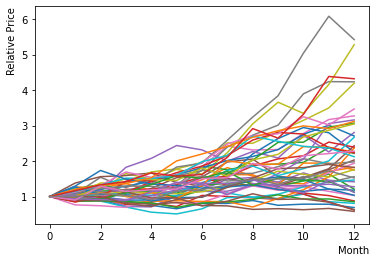

In [36]:
#相関正規確率変数Znの生成
def createZvariables(N, rho):
  rho_mat = np.full((N,N), rho)
  rho_mat[range(N), range(N)] = 1.0
  rho_chole = np.linalg.cholesky(rho_mat)
  zNs_temp = np.random.normal(0, 1, (10000, N))
  zNs = zNs_temp @ rho_chole
  return zNs

#チャートのブラウン運動の生成
def GetNextSt(St, mu, sigma, zN):
  Deltat = 1
  scale = np.exp((mu-0.5*sigma*sigma)*Deltat + sigma*zN*np.sqrt(Deltat))
  NextSt = St * scale
  return NextSt

Nassets = 48 #生成する銘柄の数
chart = list()
ZList = list()
Zvariables = createZvariables(Nassets, rho)
Zlabels = random.sample([x for x in range(10000)], 12) #Z variable shuffle

for label in Zlabels:
  ZList.append(Zvariables[label])

for iasset in range(Nassets):
  chart_asset = [1.0] #初値 相対価格で1.0

  #12ステップ（か月）シミュレーションを行う
  for month in range(12):
    chart_asset.append(GetNextSt(chart_asset[month], mu, sigma, ZList[month][iasset]))

  chart.append(chart_asset)
  #print(chart_asset) #各銘柄の具体的な数値をプリント
  plt.plot(list(range(13)), chart_asset)

plt.xlabel("Month", loc="right")
plt.ylabel("Relative Price", loc="top")
plt.show()

次に各銘柄のSharpe Ratioを計算します。ここでは先程の結果を評価するに実現Sharpe Ratioを用います。その定義に従い、無リスク利回り率を超過した超過収益率の平均$\bar{r}$と超過リターン率の標準偏差$\sigma$から求めましょう。チャートの確認から判明したように、銘柄数が少ない場合は偶然による偏りが大きい・生成条件に銘柄間の相関による影響があるため、銘柄を100回生成しその平均Shape Ratioを確認することでそれらの影響を減らします。結果として、銘柄の平均Sharpe Ratioが期待通り$0.4$になるのが確認できます。またSharpe Ratioの計算定義を変更した場合には、当然Sharpeの値が変化することが確認できますが、おおむね$0.40\pm0.05$の範囲内には収まることもわかります。

In [37]:

#銘柄生成関数
def CreateAssets(Nassets): 
  chart = list()
  ZList = list()
  Zvariables = createZvariables(Nassets, rho)
  Zlabels = random.sample([x for x in range(10000)], 12)
  for label in Zlabels:
    ZList.append(Zvariables[label])
  for iasset in range(Nassets):
    chart_asset = [1.0]
    for month in range(12):
      chart_asset.append(GetNextSt(chart_asset[month], mu, sigma, ZList[month][iasset]))
    chart.append(chart_asset)
  return chart

#オーソドックスなSharpe Ratio
def CalculateSharpeRatio(asset):
    monthly_return = list()
    for month in range(12):
      valueChange = asset[month+1]/asset[month] - 1.0 - r0
      monthly_return.append(valueChange)

    annualized_excess_return = np.mean(monthly_return)
    volatility = np.std(monthly_return, ddof=1)

    return(annualized_excess_return/volatility)

#log-returnに基づいたSharpe Ratio
def CalculateSharpeRatio_log(asset):
  monthly_log_return = list()
  for month in range(12):
    valueChange = np.log(asset[month+1]/asset[month])
    monthly_log_return.append(valueChange)
  mean_log_return = np.mean(monthly_log_return)
  volatility = np.std(monthly_log_return, ddof=1)

  return (mean_log_return-r0)/volatility

#少し変わった定義のSharpe Ratio
def CalculateSharpeRatio_2(asset):
  monthly_log_return = list()
  monthly_return = list()
  for month in range(11):
    log_valueChange = np.log(asset[month+1]/asset[month])
    monthly_log_return.append(log_valueChange)
    valueChange = asset[month+1]/asset[month] - 1.0
    monthly_return.append(valueChange)
  annualized_excess_return = np.mean(monthly_return) - r0
  volatility = np.std(monthly_log_return, ddof=1)

  return (annualized_excess_return/volatility)

allmean = 0
for ntry in range(100): #複数回試行で同じセットないの相関による影響を消す
  Chart = CreateAssets(48) #指定した数の銘柄を作る
  mean_SR = 0.0
  n = 0.
  for asset in Chart:
    assetSR = CalculateSharpeRatio(asset) #ここを変更すればShape Ratioの計算方法を変えられる
    #assetSR = CalculateSharpeRatio_log(asset)
    #assetSR = CalculateSharpeRatio_2(asset)
    mean_SR = ((mean_SR*n)+assetSR) / (n+1) #平均Shape Ratio
    n+=1
  print("SubSet "+ str(ntry)+ " average Sharpe Ratio: " + str(mean_SR))
  allmean = ((allmean*ntry)+mean_SR) / (ntry+1)
  print("Average Sharpe Ratio of all generated: "+ str(allmean))

SubSet 0 average Sharpe Ratio: 0.31893263823879553
Average Sharpe Ratio of all generated: 0.31893263823879553
SubSet 1 average Sharpe Ratio: 0.5003430271047052
Average Sharpe Ratio of all generated: 0.40963783267175036
SubSet 2 average Sharpe Ratio: 0.4213650111154403
Average Sharpe Ratio of all generated: 0.41354689215298035
SubSet 3 average Sharpe Ratio: 0.3821756513970873
Average Sharpe Ratio of all generated: 0.4057040819640071
SubSet 4 average Sharpe Ratio: 0.342759684332834
Average Sharpe Ratio of all generated: 0.3931152024377725
SubSet 5 average Sharpe Ratio: 0.5117713912230796
Average Sharpe Ratio of all generated: 0.41289123390199034
SubSet 6 average Sharpe Ratio: 0.5136315654976834
Average Sharpe Ratio of all generated: 0.4272827098442322
SubSet 7 average Sharpe Ratio: 0.4522800197758876
Average Sharpe Ratio of all generated: 0.43040737358568915
SubSet 8 average Sharpe Ratio: 0.451732019013867
Average Sharpe Ratio of all generated: 0.43277677863326447
SubSet 9 average Sharpe

### 古典アルゴリズムによる探索
次にQUBO行列の準備及び古典なアルゴリズムに必要な関数を実装します。ここで、ペアワイズ相関行列は論文に従い対数リターンで計算を行います。

In [38]:
import heapq
import pandas as pd
import copy

#Attractiveness Coversion
def SRBucket(SR_list):
    Buckets=sorted(SR_list)
    Buckets.reverse()
    GroupedList = list(np.array_split(Buckets,11))
    for i in range(len(SR_list)):
        if   SR_list[i] in GroupedList[0]: SR_list[i]=15
        elif SR_list[i] in GroupedList[1]: SR_list[i]=12
        elif SR_list[i] in GroupedList[2]: SR_list[i]=9
        elif SR_list[i] in GroupedList[3]: SR_list[i]=6
        elif SR_list[i] in GroupedList[4]: SR_list[i]=3
        elif SR_list[i] in GroupedList[5]: SR_list[i]=0
        elif SR_list[i] in GroupedList[6]: SR_list[i]=-3
        elif SR_list[i] in GroupedList[7]: SR_list[i]=-6
        elif SR_list[i] in GroupedList[8]: SR_list[i]=-9
        elif SR_list[i] in GroupedList[9]: SR_list[i]=-12
        elif SR_list[i] in GroupedList[10]: SR_list[i]=-15

#Penalty/Reward Conversion 
def CorrelationBucket(Corr):
    for i in range(len(Corr)):
        for j in range(len(Corr)):
            if Corr[i][j] >= -1.00 and  Corr[i][j] < -0.25: Corr[i][j] = -5
            elif Corr[i][j] >= -0.25 and  Corr[i][j] < -0.15: Corr[i][j] = -3
            elif Corr[i][j] >= -0.15 and  Corr[i][j] < -0.05: Corr[i][j] = -1
            elif Corr[i][j] >= -0.05 and  Corr[i][j] < 0.05: Corr[i][j] = 0
            elif Corr[i][j] >= 0.05 and  Corr[i][j] < 0.15: Corr[i][j] = 1
            elif Corr[i][j] >= 0.15 and  Corr[i][j] < 0.25: Corr[i][j] = 3
            elif Corr[i][j] >= 0.25 and  Corr[i][j] < 1.00: Corr[i][j] = 5

#Ising component for classical algorithms
def hi(SR_list, Corr, i):
    h = 0.5*SR_list[i] + np.sum(Corr[i])
    return h

def jij(Corr, i, j):
    return 1./4.*Corr[i][j]

#Create Pairwise Correlation Matrix
def CreateCorrMat(Chart):
    assets = list()
    for iasset in range(len(Chart)):
        returns = list()
        for month in range(12):
            log_return = np.log(Chart[iasset][month+1]/Chart[iasset][month])
            returns.append(log_return)
        assets.append(returns)
    Chart_pd = pd.DataFrame(assets).T
    pairwise_corr = Chart_pd.corr(method='pearson')
    return pairwise_corr

#Initial state for Greedy Search and Genetic Algorithm
def GenerateRandomSolution(Nassets):
    Solution = np.random.randint(2, size=Nassets)
    for i in range(Nassets):
        Solution[i] = 2*Solution[i] - 1
    return Solution

#得られた解のポートフォリオのSharpe Ratioを計算する
def EvaluateSolution(Solution,Chart):
    selected_assets = list()
    for i in range(len(Solution)):
        if Solution[i] == 1:
            selected_assets.append(Chart[i])
    portfolioChart = np.mean(selected_assets, axis=0)
    portfolioSR = CalculateSharpeRatio(portfolioChart)
    return portfolioSR

#遺伝アルゴリズム、突然変異を導入して子孫を作る
def CreateDescendant(Ancestor, Ndescendants, MaxMutation):
    n = 0
    index_list = range(len(Ancestor))
    Descendants = list()
    while n < Ndescendants:
        Nmutaion = np.random.randint(MaxMutation)
        Place_to_change = np.random.choice(index_list, size=Nmutaion, replace=False)
        Descendant = list()
        for place in Place_to_change:
            Descendant = copy.deepcopy(Ancestor)
            Descendant[place] = Ancestor[place] * -1
            Descendants.append(Descendant)
        n += 1
    return Descendants

In [39]:
#銘柄セットを再生成する
#ここからさっきのステップはこの銘柄セットをずっと使う
Nassets = 48

Chart = CreateAssets(Nassets)
PairwiseCorrMat = CreateCorrMat(Chart)
SR_list = list()

for asset in Chart:
    SR_list.append(CalculateSharpeRatio(asset))

#Bucketの翻訳
SRBucket(SR_list)
CorrelationBucket(PairwiseCorrMat)

#print(PairwiseCorrMat)　#ペアワイズ相関行列の確認

#### 貪欲法による探索

まずは貪欲法アルゴリズムによる探索を行います。ランダムに生成した初期状態から出発し、全体のパフォーマンスに対する影響を見ながら、ポートフォリオのSharpe Ratioを高くできそうな銘柄を選んでいきます。反復を行うことで、ランダムな初期状態からある一定の状態に落ち着くことが観測できます。

実行後、初期状態と貪欲法で得られた状態の比較を行います。このときの比較基準はポートフォリオのSharpe Ratioとします。このチュートリアルでは全銘柄のウエイトが同じというシナリオで計算を行なっているため、選ばれた銘柄の平均的なチャートを得てSharpe Ratioの計算を行っています。

また、一個前のコードブロックを複数回実行して銘柄セットをリセットすると、貪欲法の結果が初期状態よりも悪くなったり、ほぼ変わらなかったりする場合もあることがわかります。また最終的なリターンが初期状態に負けているが、Sharpe Ratioが大きいという最終状態も出現します。それらを比較すると、Sharpe Ratioが大きい場合のポートフォリオはチャートが滑らかで、変動が小さい(リスクが小さい)ことが分かります。

Initial random selection:
[-1 -1 -1 -1  1  1  1  1 -1  1 -1  1 -1  1  1 -1 -1 -1 -1 -1  1  1 -1 -1
 -1  1 -1  1 -1  1 -1 -1  1 -1 -1 -1 -1  1  1  1 -1 -1  1 -1 -1 -1  1  1] 1.1819620775282662

Selection After Greedy Search:
[-1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1  1 -1 -1  1
 -1 -1  1 -1  1 -1 -1  1  1  1  1 -1 -1 -1  1 -1 -1  1 -1  1  1 -1 -1  1] 3.133413105046622



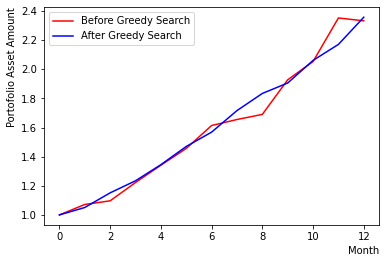

In [40]:
#Greedy Search

#初期状態生成
Solution = GenerateRandomSolution(Nassets)
print("Initial random selection:")
print(Solution, EvaluateSolution(Solution, Chart))
print("")

selected_charts = list()
for i in range(Nassets):
    if Solution[i] == 1:
        selected_charts.append(Chart[i])
portfolioChart = np.mean(selected_charts, axis=0)

#初期状態に基づいてエネルギーの初期化を行う
Energies = list()
for iasset in range(Nassets):
    h = hi(SR_list, PairwiseCorrMat, iasset)
    energyTuple = [-1*abs(h), h , iasset]
    Energies.append(energyTuple)

#貪欲サーチの実行
NGreedyLoop = 10
for i in range(NGreedyLoop):
    heapq.heapify(Energies)

    ntry = 0
    #print(Energies) #エネルギー変化を確認
    while(ntry < len(Energies)):
        x, e, i = heapq.heappop(Energies)
        if e > 0:
            Solution[i] = -1.
        else:
            Solution[i] = 1.
        for ie in Energies:
            n = ie[2]
            ie[1] = ie[1] + Solution[i]*(jij(PairwiseCorrMat, i, n) + jij(PairwiseCorrMat, n, i))
            ie[0] = -ie[1]
        ntry+=1


#貪欲サーチの出力
print("Selection After Greedy Search:")
print(Solution, EvaluateSolution(Solution, Chart))
print("")

selected_charts2 = list()
for i in range(Nassets):
    if Solution[i] == 1:
        selected_charts2.append(Chart[i])
portfolioChart2 = np.mean(selected_charts2, axis=0)

plt.plot(list(range(13)), portfolioChart,color="r",label="Before Greedy Search")
plt.plot(list(range(13)), portfolioChart2,color="b",label="After Greedy Search")
plt.xlabel("Month", loc="right")
plt.ylabel("Portofolio Asset Amount", loc="top")
plt.legend()
plt.show()

#### 遺伝的アルゴリズム

貪欲法のほかに使われた古典アルゴリズムとして、遺伝的アルゴリズムがあります。ランダムに生成した複数のポートフォリオからパフォーマンスが良いものを選択し、その良いポートフォリオをもとにして次の世代のポートフォリオを生成します。次の世代のポートフォリオは、前の世代のポートフォリオにランダムな変更を加える突然変異と、ポートフォリオ間の遺伝子を交換させる操作などから生成されます。ここでは銘柄数が比較的小さいため、突然変異のみを考えて、遺伝子間の交換などは行わないものとします。

結果を比較することで、最後に計算された世代のパフォーマンスは第一世代よりも良くなっていることがわかります。ただし、ここでは試行した世代数が限られているため、パフォーマンスが改善されないまたは改善が小さい場合もあります。しかし、総じて貪欲法よりも安定な出力が得られることも観察できます。

注意：遺伝子の組数や子孫数そして変異の数を増やした場合、計算量の増加により計算が終わらない場合もあります。実行環境に合わせて設定を変更してください。

Best Gene 1st generation:
[ 1  1 -1 -1  1 -1  1  1 -1 -1  1 -1 -1 -1  1 -1 -1  1 -1 -1 -1 -1  1 -1
  1  1 -1 -1 -1 -1  1 -1 -1  1  1  1  1 -1  1  1 -1 -1 -1  1 -1  1  1 -1] 1.3900713054121818

Best Gene last generation:
[ 1 -1 -1 -1  1  1 -1  1  1 -1 -1 -1 -1  1  1  1  1 -1 -1 -1 -1  1  1  1
  1 -1 -1 -1  1  1  1  1 -1  1  1 -1 -1  1 -1  1 -1  1 -1 -1  1  1 -1  1] 1.547297840627872



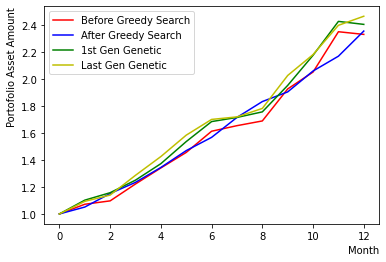

In [41]:
#Genetic Algorithm
Ngenes = 10 #遺伝子の組数
NGenerations = 5 #世代数
#ランダム初期化
Genes = list()
for i in range(Ngenes):
    gene = GenerateRandomSolution(Nassets)
    geneSR = EvaluateSolution(gene, Chart)
    Genes.append([geneSR, gene])
Genes = sorted(Genes,reverse=True)

#第一世代最優良ポートフォリオ
print("Best Gene 1st generation:")
print(Genes[0][1], EvaluateSolution(Genes[0][1], Chart))
print("")

selected_charts3 = list()
for i in range(Nassets):
    if Genes[0][1][i] == 1:
        selected_charts3.append(Chart[i])
portfolioChart3 = np.mean(selected_charts3, axis=0)


#遺伝的アルゴリズム実行
K_best = 5 #上位抽出遺伝子組数
Ndescendants = 2 #子孫数
MaxMutation = 2 #最大変異数
for iIter in range(NGenerations):
    selected_Genes = Genes[:K_best]
    for gene in selected_Genes:
        Descendants = CreateDescendant(gene[1], Ndescendants, MaxMutation)
        for Descendant in Descendants:
            DescendantSR = EvaluateSolution(Descendant, Chart)
            selected_Genes.append([DescendantSR, Descendant])
    selected_Genes = sorted(selected_Genes, key=lambda x: x[0], reverse=True)
    selected_Genes = copy.deepcopy(selected_Genes[:K_best])

#ラスト世代最優良ポートフォリオ
print("Best Gene last generation:")
print(selected_Genes[0][1], EvaluateSolution(selected_Genes[0][1], Chart))
print("")
selected_charts4 = list()
for i in range(Nassets):
    if selected_Genes[0][1][i] == 1:
        selected_charts4.append(Chart[i])
portfolioChart4 = np.mean(selected_charts4, axis=0)

#比較プロットを作る
plt.plot(list(range(13)), portfolioChart,color="r",label="Before Greedy Search")
plt.plot(list(range(13)), portfolioChart2,color="b",label="After Greedy Search")
plt.plot(list(range(13)), portfolioChart3,color="g",label="1st Gen Genetic")
plt.plot(list(range(13)), portfolioChart4,color="y",label="Last Gen Genetic")
plt.xlabel("Month", loc="right")
plt.ylabel("Portofolio Asset Amount", loc="top")
plt.legend()
plt.show()


## OpenJijを用いた量子アニーリング手法の実装

### Quantum Annealingによる解法
Reverse Quantum Annealingでこの最適問題解くために、古典なアルゴリズムで得られたスピン形式の結果をアニーリングが使う形式に変換しましょう。

In [42]:
def ConvertSolutionToQuboState(solution):
    output = list()
    for i in range(len(solution)):
        if solution[i] == 1:
            output.append(1)
        else: output.append(0)
    return output

QA_init_state = ConvertSolutionToQuboState(Solution) #貪欲サーチの結果を初期状態として使う
#QA_init_state = ConvertSolutionToQuboState(selected_Genes[0][1]) #遺伝的アルゴリズムラスト世代の最優良ポートフォリオを初期状態として使う
#QA_init_state = GenerateRandomSolution(Nassets) #ランダムな初期状態を使う
print(QA_init_state)    

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1]


#### Forward Annealingの場合
まずはForward Annealingを実行してみましょう。銘柄の魅力度とペアワイズ相関による罰金と賞金の度合を使ってQUBO行列を作ります。以下では量子アニーリングを古典計算機上でシミュレートするSimulated Quantum Annealing (SQA)を用いて計算を行います。最終リターン率の改善は場合によりますが、貪欲法で得られた結果よりも安定したチャートを得られていることがわかります。

<class 'numpy.ndarray'>


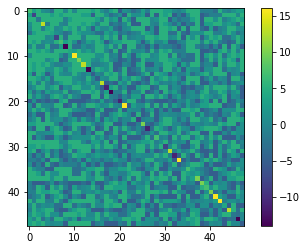

[([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1], -287., 1)
 ([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1], -287., 1)
 ([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1], -287., 1)
 ([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1], -287., 1)
 ([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1], -287., 1)
 ([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1], -287., 1)
 ([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1

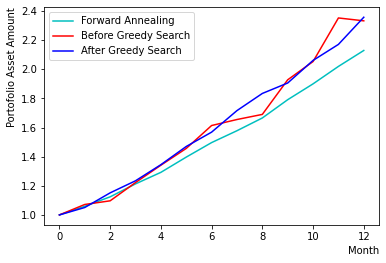

In [43]:
from openjij import SQASampler
sampler = SQASampler()

QUBO = np.random.rand(Nassets**2).reshape(Nassets, Nassets)
for i in range(Nassets):
    for j in range(Nassets):
        QUBO[i][j] = PairwiseCorrMat[i][j]
for i in range(Nassets):
    QUBO[i][i] = QUBO[i][i] + SR_list[i]

print(type(QUBO))
import matplotlib.pyplot as plt
plt.imshow(QUBO)
plt.colorbar()
plt.show()

sampleset_FQA = sampler.sample_qubo(QUBO,num_reads=10)
print(sampleset_FQA.record)
print(sampleset_FQA.record[0][0], EvaluateSolution(sampleset_FQA.record[0][0], Chart))
selected_charts = list()
for i in range(Nassets):
    if sampleset_FQA.record[0][0][i]:
        selected_charts.append(Chart[i])
portfolioChart_FQA = np.mean(selected_charts, axis=0)
plt.plot(list(range(13)), portfolioChart_FQA, color="c", label="Forward Annealing")
plt.plot(list(range(13)), portfolioChart,color="r",label="Before Greedy Search")
plt.plot(list(range(13)), portfolioChart2,color="b",label="After Greedy Search")
plt.xlabel("Month", loc="right")
plt.ylabel("Portofolio Asset Amount", loc="top")
plt.legend()
plt.show()

#### Reverse Quantum Annealing(RQA)の場合
Reverse Annealingの場合、まずは古典的アルゴリズムから得られた状態を初期状態として入力してからアニーリングを行います。まずはアニーリングのスケジュールの設定です。ここではOpenJijを用いてSQAのハミルトニアンは次のように定めます。

$$
\mathcal{H}_{\mathrm{SQA}}(s) = s\mathcal{H}_{p}-(1-s)\sum_{i}\sigma_{i}^{x}, 0\leq x\leq 1
$$

ここで$\mathcal{H}_{p}$は最適解を求めたい問題ハミルトニアンで、$s$と$1-s$はそれぞれ参考論文[2]の$B[t]$と$A[t]$に対応します。この$s$は

```python
sample_qubo(QUBO, num_reads=10)
```

に追加の引数を指定することによって設定できます。初期状態の設定や更新を含めて、先程の`sample_qubo`部分を

```python
sample_qubo(QUBO, schedule = user_schedule, initial_state = user_initial_state, num_reads=10, reinitialize_state = False)
```

のように変更すれば良いでしょう。ここのscheduleはアニーリングスケジュールを指しており

```python
user_schedule = [
    [0, 0.1, 4], #s=0, beta=0.1, 4 steps
    [0.5, 1, 3],  #s=0, beta=1, 3 steps
    [1, 10, 3]  #s=1, beta=10, 3 steps
]
```

のような構造を持ちます。格納されたリストの```[0]```成分は$s$の値で、アニーリング時の横磁場の強さを反映しています。```[1]```成分は逆温度$\beta$を表しています。大きければ低い温度を意味し、より基底状態に到達しやすくなります（デフォルトでは$\beta = 5$で設定されています。）そして最後の```[2]```成分は量子モンテカルロ法のシミュレーションステップ数を表しており、各スケジュールの長さを調整できます。

`initial_state`の引数に代入する初期状態を指定します。`reinitialize_state`のオプションを`False`にすると、反復実行において前ステップでのアニーリング出力が次のステップのアニーリング初期状態として代入されます。上述のスクリプト例では、古典アルゴリズムで準備された初期状態から出発し、RQAを10回実行することになります。このオプション引数のデフォルトである`True`では、実行するたびに初期状態の再設定を行います。RQAを一回実行し、複数回の結果を比較したい場合は`reinitialize_state = True`にすると良いでしょう。

ではReverse Annealingのスケジュールを作成しましょう。OpenJijのsamplerは指定された$s$と$\beta$を指定したMC step数で量子モンテカルロを実行するため、短い定数をつなぎ合わせて$s$や$\beta$が少しずつ変化するようなスケジュールを作り、RQAを動作させる必要があります。ここでは$s$の変化に注目してそれをプロットすると逆さまの台形のスケジュールを確認できます。横軸は量子モンテカルロ法のモンテカルロステップ数を表します。スケジュール作成関数の中身を書き換えれば、そのほかの形のスケジュールを自在に作成することができます。

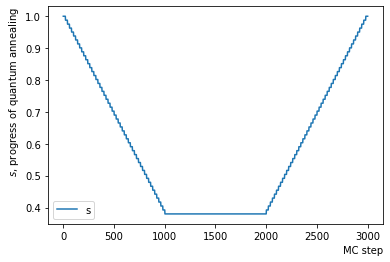

In [44]:
def ScheduleFunction(x, RQAschedule):
    for step in RQAschedule:
        length = step[2]
        if x - length > 0:
            x = x-length
            continue
        else:
            s = step[0]
            return s


def ConvertScheduleToPlot(RQAschedule):
    TotalLength = np.sum(RQAschedule, axis=0)[2]
    x = np.arange(0, TotalLength+1)
    s = [ScheduleFunction(n, RQAschedule) for n in x]
    plt.plot(x, s ,label="s")
    plt.xlabel("MC step", loc="right")
    plt.ylabel("$s$, progress of quantum annealing", loc="top")
    plt.legend()
    plt.show()

#Create RQA schedule
RQAschedule = []
NReverseStep = 50
NPauseStep = 50
NForwardStep = 50
NMCStep = 20
TargetS = 0.38
ReverseStep = (1.0 - TargetS) / NReverseStep
ForwardStep = (1.0 - TargetS) / NForwardStep
beta = 5.
#Reverse Step
for i in range(NReverseStep):
    step_sche = [1.0-i*ReverseStep, beta, NMCStep]
    RQAschedule.append(step_sche)   

#Pause Step
RQAschedule.append([TargetS, beta, NPauseStep*NMCStep])

#Forward Step
for i in range(NForwardStep):
    step_sche = [TargetS+(i+1)*ForwardStep, beta, NMCStep]
    RQAschedule.append(step_sche)

#Plot Annealing Schedule
ConvertScheduleToPlot(RQAschedule)

このようにして作成されたスケジュールと初期状態を指定した`sample_qubo`関数を用いて、RQAを実行しましょう。同時に貪欲法の結果やForward Annealingの結果の比較を行います。結果を見ると、このチュートリアルが行う設定では銘柄セットのサイズ制限によりForward Annealingと同じ最適解にたどり着く場合が多いことがわかります。

[([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1], -287., 1)
 ([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1], -287., 1)
 ([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1], -287., 1)
 ([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1], -287., 1)
 ([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1], -287., 1)
 ([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1], -287., 1)
 ([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1

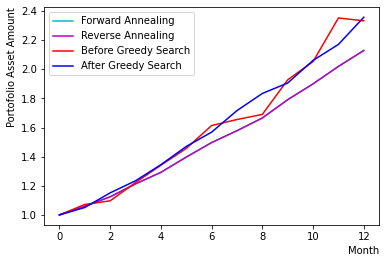

Forward Quantum Annealing Result:
[0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 1 1 1 0 1 1 1 0 0 1 1 1 1 0 0
 0 1 0 0 0 0 1 1 0 1 1] 5.278116764964878
Reverse Quantum Annealing Result:
[0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 1 1 1 0 1 1 1 0 0 1 1 1 1 0 0
 0 1 0 0 0 0 1 1 0 1 1] 5.278116764964878


In [45]:
#初期状態を準備
init_state = QA_init_state

#Reverse Annealing
sampleset_RQA = sampler.sample_qubo(QUBO, schedule=RQAschedule, initial_state = init_state, num_reads=10, reinitialize_state=False)
print(sampleset_RQA.record)

#チャートの比較
selected_charts = list()
for i in range(Nassets):
    if sampleset_RQA.record[0][0][i]:
        selected_charts.append(Chart[i])
portfolioChart_RQA = np.mean(selected_charts, axis=0)
plt.plot(list(range(13)), portfolioChart_FQA, color="c", label="Forward Annealing")
plt.plot(list(range(13)), portfolioChart_RQA, color="m", label="Reverse Annealing")
plt.plot(list(range(13)), portfolioChart,color="r",label="Before Greedy Search")
plt.plot(list(range(13)), portfolioChart2,color="b",label="After Greedy Search")
plt.xlabel("Month", loc="right")
plt.ylabel("Portofolio Asset Amount", loc="top")
plt.legend()
plt.show()
#結果の比較
print("Forward Quantum Annealing Result:")
print(sampleset_FQA.record[0][0], EvaluateSolution(sampleset_FQA.record[0][0], Chart))
print("Reverse Quantum Annealing Result:")
print(sampleset_RQA.record[0][0], EvaluateSolution(sampleset_RQA.record[0][0], Chart))

### Reverse Quantum Annealingの確認
最終出力だけではRQAの振る舞いが分からないため、Phaseを分解してRQAを実行し、その挙動を見てみましょう。まずはReverse Phaseの確認です。同様にアニーリングスケジュールを設定し、スケジュールと初期状態を指定したアニーリングを行います。ここでは分かりやすくするためにReverse Phaseが止まる$s$の値や逆温度の設定を変更しています。またアニーリングも反復実行するのではなく、毎回同じ初期状態から始まるように設定しました。結果を見ると、Reverse phaseの過程により、既に得られた解からよりエネルギーの高い状態に登っていることがわかります。また実行ごとに異なる状態で留まるため、高いエネルギー準位で解が定まっていない様子も伺えます。

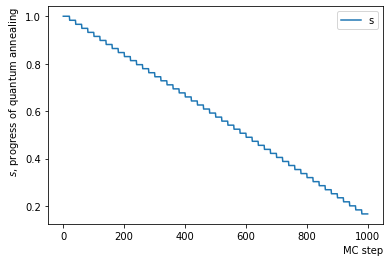

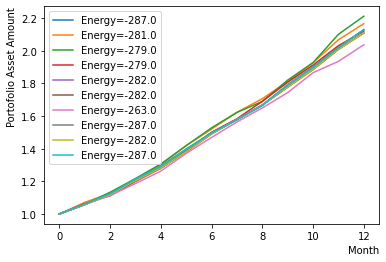

[([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1], -287., 1)
 ([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1], -281., 1)
 ([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1], -279., 1)
 ([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1], -279., 1)
 ([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1], -282., 1)
 ([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1], -282., 1)
 ([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0

In [46]:
#Create RQA schedule
RQAschedule = []
NReverseStep = 50
TargetS = 0.15 #よりランダムな状態に戻す
ReverseStep = (1.0 - TargetS) / NReverseStep
beta = 5.0
MC_step = 20
#Reverse Step
for i in range(NReverseStep):
    step_sche = [1.0-i*ReverseStep, beta, MC_step]
    RQAschedule.append(step_sche)   

ConvertScheduleToPlot(RQAschedule)
init_state = QA_init_state 
    

sampleset_RQA_Reverse = sampler.sample_qubo(QUBO, schedule=RQAschedule, initial_state = init_state, num_reads=10, reinitialize_state=True) #毎回同じ初期状態からアニーリング
for state in sampleset_RQA_Reverse.record:
    selected_charts = list()
    for i in range(Nassets):
        if state[0][i]:
            selected_charts.append(Chart[i])
    portfolioChart = np.mean(selected_charts, axis=0)
    plt.plot(list(range(13)), portfolioChart, label=("Energy="+str(state[1])))

plt.xlabel("Month", loc="right")
plt.ylabel("Portofolio Asset Amount", loc="top")
plt.legend()
plt.show()
print(sampleset_RQA_Reverse.record)

次はPause Phaseの追加を行いましょう。追加後は同様にアニーリングを実行し、その結果を確認します。このPhaseの追加は実装上において上のReverse Phaseの一番最後のステップのMCステップ数を伸ばしたものに等しいため、上のReverseのみのケースと同じようにバラバラの結果となります。

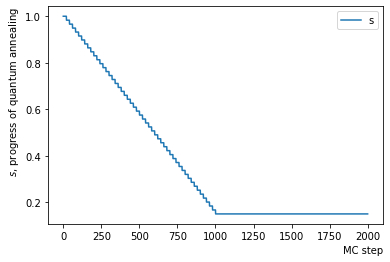

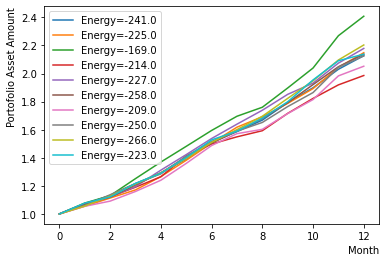

[([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1], -241., 1)
 ([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1], -225., 1)
 ([0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1], -169., 1)
 ([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1], -214., 1)
 ([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1], -227., 1)
 ([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1], -258., 1)
 ([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0

In [47]:
#Create Pause Step
NPauseStep = 50
TargetS = 0.15 #よりランダムな状態に戻す
beta = 1.0 #より高い温度で熱的動きがしやすくようにする
MC_step = 20
step_sche = [TargetS, beta, MC_step*NPauseStep]
RQAschedule.append(step_sche)

#print(RQAschedule)
ConvertScheduleToPlot(RQAschedule)
init_state = QA_init_state 

sampleset_RQA_Reverse_Pause = sampler.sample_qubo(QUBO, schedule=RQAschedule, initial_state = init_state, num_reads=10, reinitialize_state=True) #毎回同じ初期状態からアニーリング
for state in sampleset_RQA_Reverse_Pause.record:
    selected_charts = list()
    for i in range(Nassets):
        if state[0][i]:
            selected_charts.append(Chart[i])
    portfolioChart = np.mean(selected_charts, axis=0)
    plt.plot(list(range(13)), portfolioChart, label=("Energy="+str(state[1])))

plt.xlabel("Month", loc="right")
plt.ylabel("Portofolio Asset Amount", loc="top")
plt.legend()
plt.show()
print(sampleset_RQA_Reverse_Pause.record)

最後にForward Phaseを追加し、アニーリングを実行します。この設定は先程のサンプルよりも少し緩い温度や磁場の条件で行いました。結果として、この銘柄セットで既知の量子アニーリングによる最適解が得られたことがわかります。RQAの節の最初の例と同様に、RQAによって最適解を発見できていることがわかります。

条件が少し緩いため解が収束せず、エネルギーが近い複数のsub-optimalの解の存在を確認することができます。それらの解の中には、場合によりForwardで得られた最適解よりも最終的なリターンが良く、形も比較的に滑らかなポートフォリオの存在も確認できます。そのポートフォリオの詳細を見ると、その大きなリターンは上昇率が大きい特定の銘柄によるもので、逆相関を持つ変動率が比較的に小さい銘柄と組み合わせて実現されたものだと分かります。実際の投資においてはそのようなポートフォリオが好ましいかもしれませんが、このチュートリアルが設定した「Shape Ratioがとにかく最大になる」条件では、相対的に小さいポートフォリSharpe Ratioが実現されたことから、量子アニーリングによって最適ではない解と判断されています。

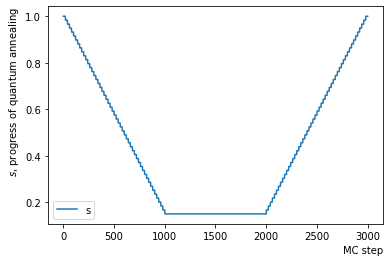

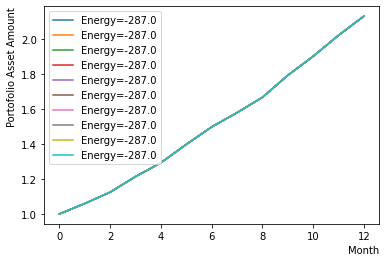

[([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1], -287., 1)
 ([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1], -287., 1)
 ([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1], -287., 1)
 ([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1], -287., 1)
 ([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1], -287., 1)
 ([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1], -287., 1)
 ([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1

In [48]:
#Create Forward Step
NForwardStep = 50
TargetS = 0.15 #よりランダムな状態に戻す
ForwardStep = (1.0 - TargetS) / NForwardStep
beta = 5.0 #より高い温度で熱的動きがしやすくようにする
MC_step = 20

#Forward Step
for i in range(NForwardStep):
    step_sche = [TargetS+(i+1)*ForwardStep, beta, MC_step]
    RQAschedule.append(step_sche)

ConvertScheduleToPlot(RQAschedule)
init_state = QA_init_state 

sampleset_RQA_Reverse_Pause_Forward = sampler.sample_qubo(QUBO, schedule=RQAschedule, initial_state = init_state, num_reads=10, reinitialize_state=True) #毎回同じ初期状態からアニーリング
for state in sampleset_RQA_Reverse_Pause_Forward.record:
    selected_charts = list()
    for i in range(Nassets):
        if state[0][i]:
            selected_charts.append(Chart[i])
    portfolioChart = np.mean(selected_charts, axis=0)
    plt.plot(list(range(13)), portfolioChart, label=("Energy="+str(state[1])))

plt.xlabel("Month", loc="right")
plt.ylabel("Portofolio Asset Amount", loc="top")
plt.legend()
plt.show()
print(sampleset_RQA_Reverse_Pause_Forward.record)


### RQAスケジュールを指定するときのパラメータ探索
Phaseを分けてReverse Quantum Annealingの様子を確認するところで、スケジュールの設定に指定した$s$,$\beta$、そして量子モンテカルロ法のステップ数によって結果が変化することが分かりました。このことから、Reverse Annealingでパフォーマンスを良くするには適切な値を設定する必要があるとわかります。

#### Reverse Phaseの場合
まずはそれらがReverse Phaseに対する影響を見てみましょう。まずは量子アニーリングの度合を表す$s$の影響から解析します。これは横磁場をどの程度強く戻すのかを表す量であり、最初のアニーリングで辿り着いた局所解の周りにあるポテンシャル障壁を越えて状態がばらけるようにするために、適切な強さ（$s$の適切な小ささ）を設定しなければなりません。このノートの結果では$s=0.20$まではReverse Phaseの終状態のばらつきがあっても不定にはならず、$s \leq 0.20$では熱的揺らぎが支配的になり、ばらつきが大きくなる様子が分かります。よって$s \sim 0.2$の近傍をさらに細かくスキャンすれば、最適の$s$値が得られると予想されます。

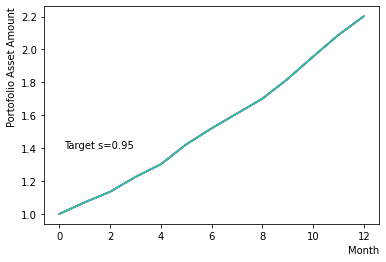

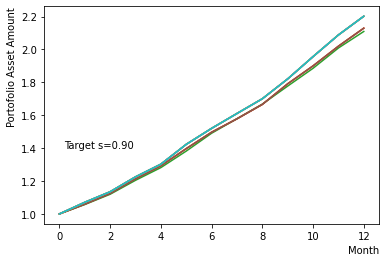

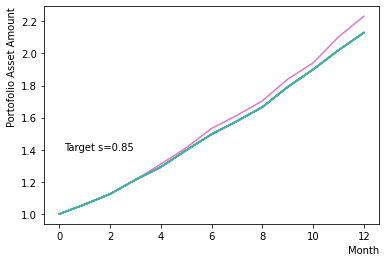

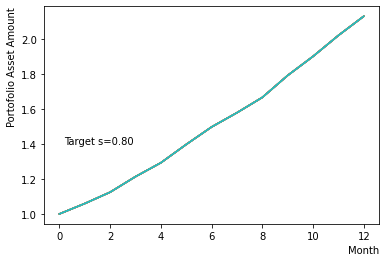

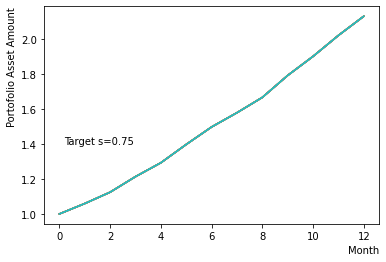

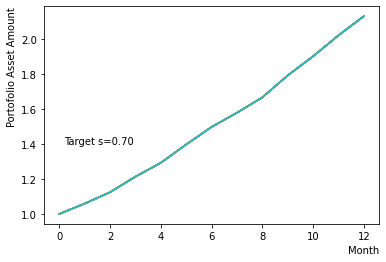

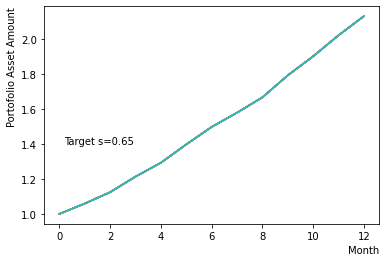

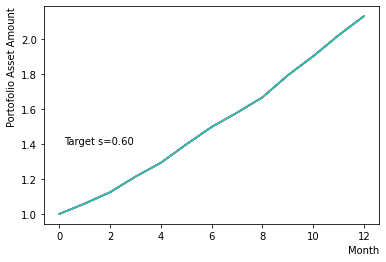

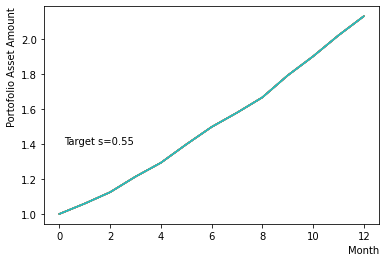

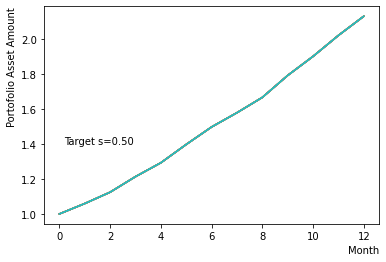

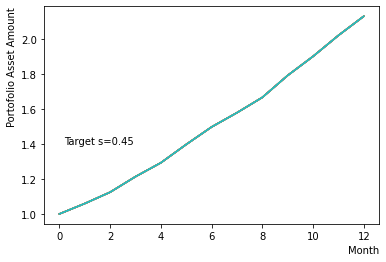

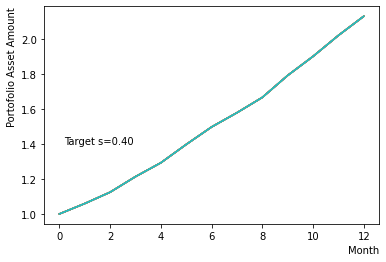

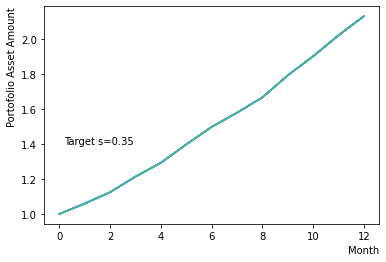

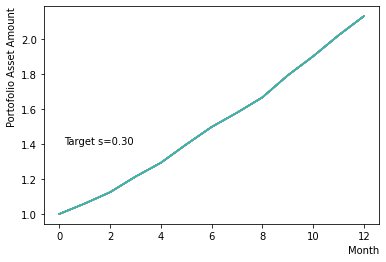

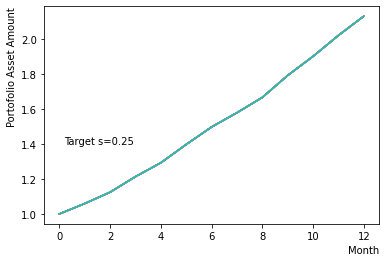

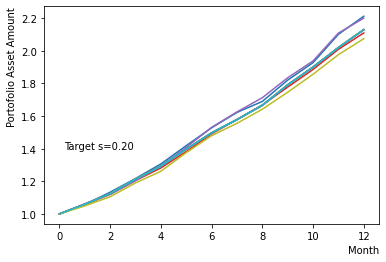

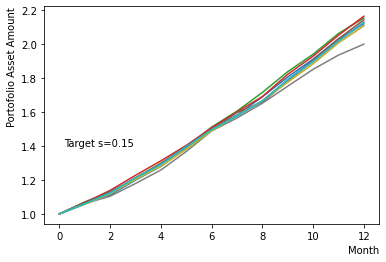

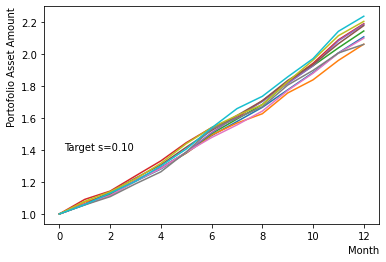

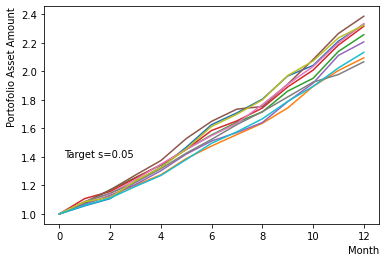

In [49]:
for TargetS in reversed(np.arange(0.05, 1.0, 0.05)):
    #Create RQA schedule
    RQAschedule = []
    NReverseStep = 50
    ReverseStep = (1.0 - TargetS) / NReverseStep
    beta = 5.0
    MC_step = 20
    #Reverse Step
    #for i in range(NReverseStep):
    for i in range(NReverseStep):
        step_sche = [1.0-i*ReverseStep, beta, MC_step]
        RQAschedule.append(step_sche)   

    init_state = QA_init_state 


    sampleset_RQA_Reverse = sampler.sample_qubo(QUBO, schedule=RQAschedule, initial_state = init_state, num_reads=10, reinitialize_state=True) #毎回同じ初期状態からアニーリング
    for state in sampleset_RQA_Reverse.record:
        selected_charts = list()
        for i in range(Nassets):
            if state[0][i]:
                selected_charts.append(Chart[i])
        portfolioChart = np.mean(selected_charts, axis=0)
        plt.plot(list(range(13)), portfolioChart, label=("Energy="+str(state[1])))
    
    plt.xlabel("Month", loc="right")
    plt.ylabel("Portofolio Asset Amount", loc="top")
    plt.text(0.2,1.4, "Target s="+'{:.2f}'.format(TargetS))
    plt.show()

次に$\beta$による影響を調べてみましょう。$\beta = \frac{1}{k_{\mathrm{B}}T}$は逆温度を表しており、$\beta$が大きければ大きいほど系がより低温であることを意味します。$\beta$が大きいほど全体としては状態がより基底状態に落ちやすく、より「Annealed」な状態に近い振る舞いをします。言い換えると横磁場が一定の場合、$\beta$が大きくなると横磁場が効きにくくなり、実効的には大きい$s$に近い振る舞いとなります。OpenJijにおいてその影響の詳細を知りたい方はこの[Qiita記事](https://qiita.com/ground0state/items/0f61c3efc7f12fd96d05)を参照すると良いでしょう。

また、その影響はQUBO行列に存在するエネルギーの典型的なスケール付近で変わることがわかっています。このチュートリアルの場合、QUBOに入っている典型な値の絶対値は大体$5$程度で収まるため、$\beta=5.0$程度で変化が起こると予想されます。

Text(0, 1, 'Number of entries')

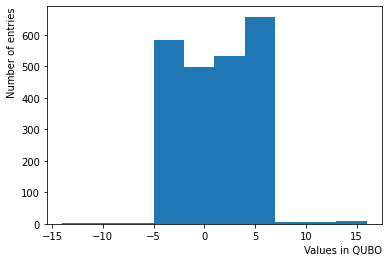

In [50]:
plt.hist((QUBO).flatten())
plt.xlabel("Values in QUBO", loc="right")
plt.ylabel("Number of entries", loc="top")

対数的な$\beta$配列を用意し、$s$以外の量は固定してReverse Phaseを行います。予想通り$\beta=5$あたりで終状態のばらつきが小さくなり、それよりも大きい$\beta$だと数少ない状態に収束してしまう様子がわかります。

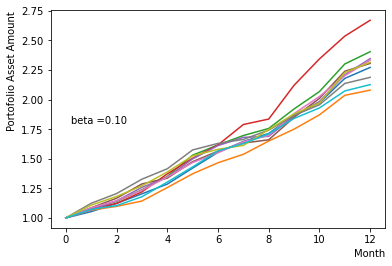

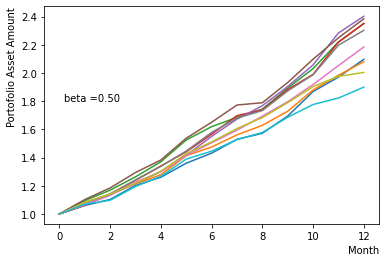

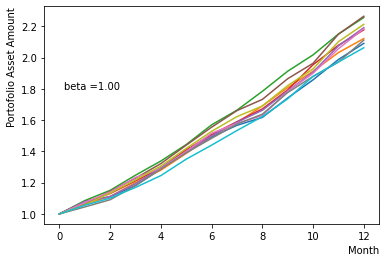

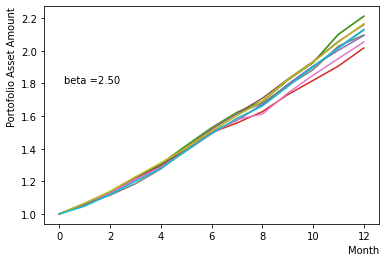

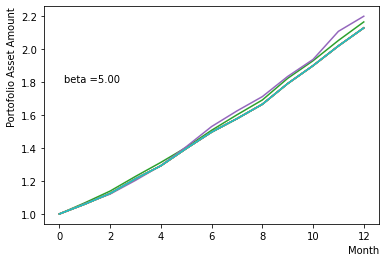

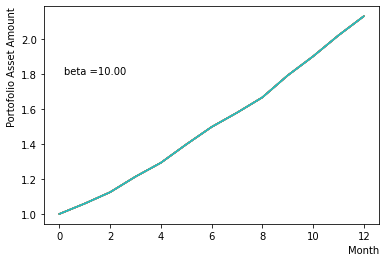

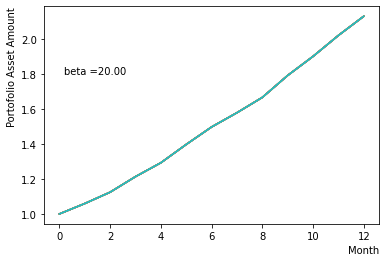

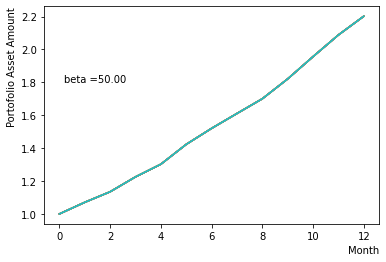

In [51]:
for beta in [0.1,0.5,1.0,2.5,5.0,10.0,20.0,50.0]:
    #Create RQA schedule
    RQAschedule = []
    NReverseStep = 50
    TargetS = 0.18
    ReverseStep = (1.0 - TargetS) / NReverseStep
    MC_step = 20
    #Reverse Step
    #for i in range(NReverseStep):
    for i in range(NReverseStep):
        step_sche = [1.0-i*ReverseStep, beta, MC_step]
        RQAschedule.append(step_sche)   

    init_state = QA_init_state 


    sampleset_RQA_Reverse = sampler.sample_qubo(QUBO, schedule=RQAschedule, initial_state = init_state, num_reads=10, reinitialize_state=True) #毎回同じ初期状態からアニーリング
    for state in sampleset_RQA_Reverse.record:
        selected_charts = list()
        for i in range(Nassets):
            if state[0][i]:
                selected_charts.append(Chart[i])
        portfolioChart = np.mean(selected_charts, axis=0)
        plt.plot(list(range(13)), portfolioChart, label=("Energy="+str(state[1])))
    
    plt.xlabel("Month", loc="right")
    plt.ylabel("Portofolio Asset Amount", loc="top")
    plt.text(0.2,1.8, "beta ="+'{:.2f}'.format(beta))
    plt.show()

そしてスケジュール分割の影響を調べましょう。ここでは階段関数のような極端的な場合から、細かく分割して緩やかな変化にする場合まで調査を行いました。結果から分かるように、分割数が少ない場合には状態があまり変化せず、逆に分割数を増やすとばらつきが見えてきます。また、大きく増やしても計算時間が長くなるだけで、結果の違いが小さいこともも分かります。このチュートリアルが取り扱うポートフォリオ最適化問題の場合は$50$程度の設定で問題ないこともわかります。

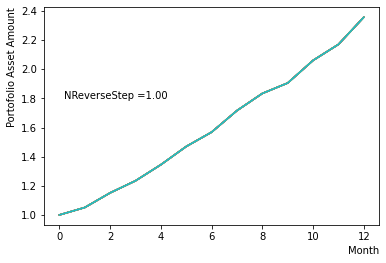

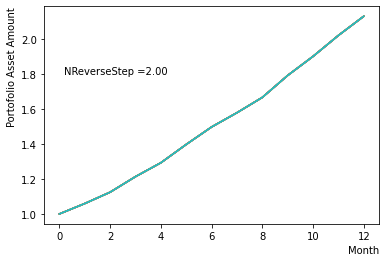

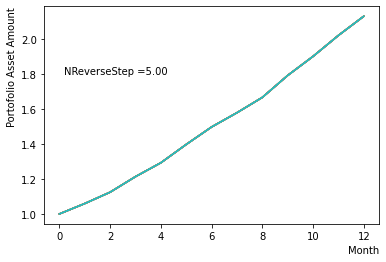

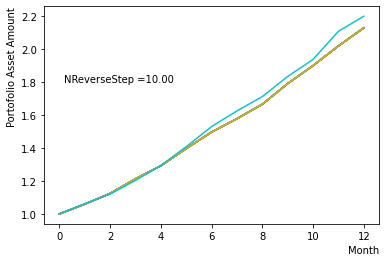

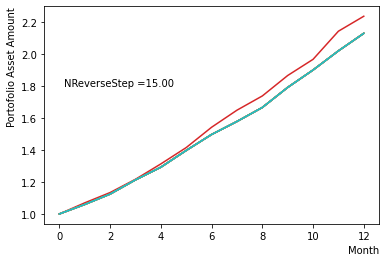

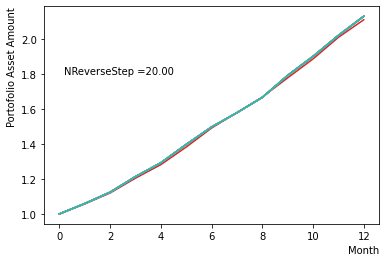

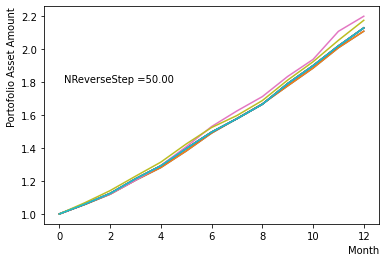

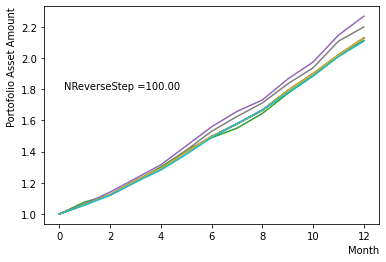

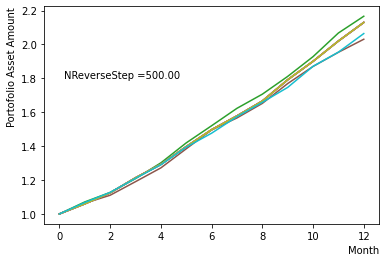

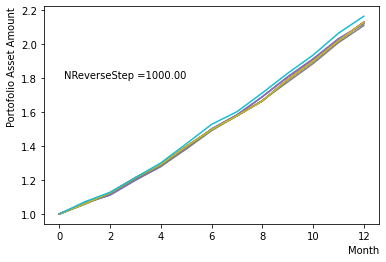

In [52]:
for NReverseStep in [1,2,5,10,15,20,50,100,500,1000]:
    #Create RQA schedule
    RQAschedule = []
    TargetS = 0.18
    ReverseStep = (1.0 - TargetS) / NReverseStep
    beta = 5.0
    MC_step = 20
    #Reverse Step
    #for i in range(NReverseStep):
    for i in range(NReverseStep):
        step_sche = [1.0-i*ReverseStep, beta, MC_step]
        RQAschedule.append(step_sche)   

    init_state = QA_init_state 


    sampleset_RQA_Reverse = sampler.sample_qubo(QUBO, schedule=RQAschedule, initial_state = init_state, num_reads=10, reinitialize_state=True) #毎回同じ初期状態からアニーリング
    for state in sampleset_RQA_Reverse.record:
        selected_charts = list()
        for i in range(Nassets):
            if state[0][i]:
                selected_charts.append(Chart[i])
        portfolioChart = np.mean(selected_charts, axis=0)
        plt.plot(list(range(13)), portfolioChart, label=("Energy="+str(state[1])))
    plt.xlabel("Month", loc="right")
    plt.ylabel("Portofolio Asset Amount", loc="top")
    plt.text(0.2,1.8, "NReverseStep ="+'{:.2f}'.format(NReverseStep))
    plt.show()

またMC stepsに関しては、(分割数)×(MC steps)が極端に少ない場合でなければ、最終の結果にはほぼ影響がないことが分かりました。`SQASampler()`でデフォルト設定の場合では、目安として$1000$程度で問題なく動作するはずです。

#### Pause Phaseの場合
既に説明したように、Pause PhaseはReverse Phaseの最後のステップを延長させたものであるため、アニーリング全体の$s$と$\beta$を変化させたところでReverse Phaseと同じようなふるまいをします。また、Pause phaseのステップ数はどのぐらい最後のステップを伸ばすのかと言う意味にに等しいため、変更してもほぼReverse Phaseの状態を保持したままであり、影響は少ないと予想されます。

ただし、Pause Phaseだけ$\beta$を変化させることは量子アニーリングが不完全な状態で古典的なアニーリングを行うことに近い行動です。ここでは$\beta=5.0$から緩やかに目標とした$\beta$に向かって系の温度を変化させた場合の影響を調べましょう。Reverse Phaseで異なる$\beta$でアニーリングを行った場合の終状態に近い結果を得ることができます。

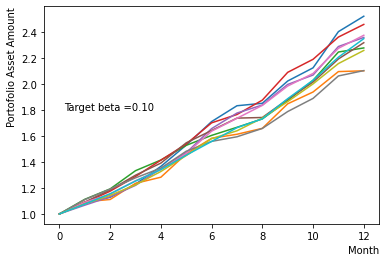

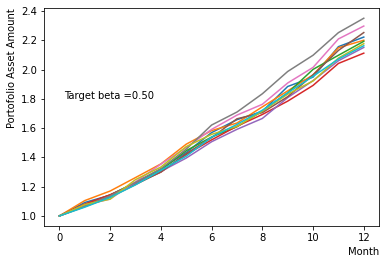

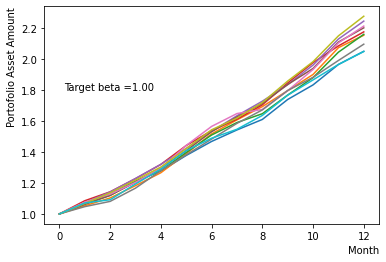

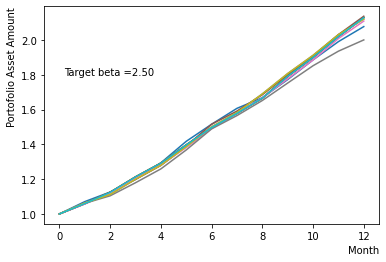

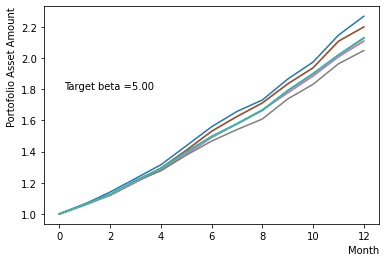

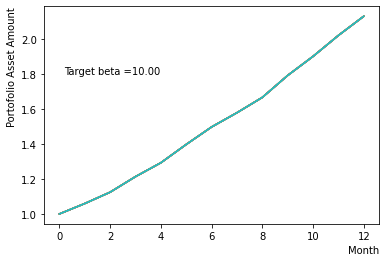

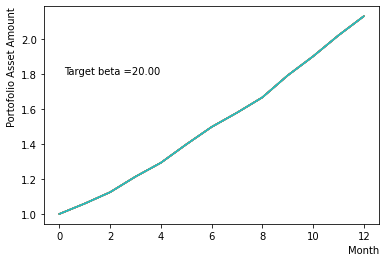

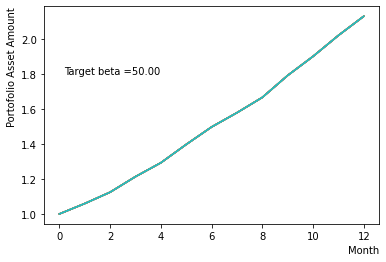

In [53]:
for beta in [0.1,0.5,1.0,2.5,5.0,10.0,20.0,50.0]:
    #Create RQA schedule
    RQAschedule = []
    NReverseStep = 50
    TargetS = 0.18
    ReverseStep = (1.0 - TargetS) / NReverseStep
    MC_step = 20
    #Reverse Step
    #for i in range(NReverseStep):
    for i in range(NReverseStep):
        step_sche = [1.0-i*ReverseStep, 5.0, MC_step]
        RQAschedule.append(step_sche) 
    
    #Pause Phase
    NPauseStep = 50
    betaStep = (5.0-beta) / NPauseStep
    for i in range(NReverseStep):
        step_sche = [TargetS, 5.0-i*betaStep, MC_step]
        RQAschedule.append(step_sche) 

    init_state = QA_init_state 


    sampleset_RQA_Reverse_Pause = sampler.sample_qubo(QUBO, schedule=RQAschedule, initial_state = init_state, num_reads=10, reinitialize_state=True) #毎回同じ初期状態からアニーリング
    for state in sampleset_RQA_Reverse_Pause.record:
        selected_charts = list()
        for i in range(Nassets):
            if state[0][i]:
                selected_charts.append(Chart[i])
        portfolioChart = np.mean(selected_charts, axis=0)
        plt.plot(list(range(13)), portfolioChart, label=("Energy="+str(state[1])))
    
    plt.xlabel("Month", loc="right")
    plt.ylabel("Portofolio Asset Amount", loc="top")
    plt.text(0.2,1.8, "Target beta ="+'{:.2f}'.format(beta))
    plt.show()

#### Forward Phaseの場合
Forwar PhaseはReverse PhaseとPause Phaseを通して得られた状態から普通の量子アニーリングを行うフェーズです。このとき考えるぺきパラメータの条件は、通常のアニーリングが正しく動作するために必要な条件と基本的に同じです。Reverse PhaseとPause Phaseと同じ方法で$\beta$と分割したステップ数のスキャンを行った結果、比較的小さい分割数と$\beta$でも結果がちゃんと最適解に収束することが分かりました。

以下にコード例を示します。Reverse PhaseとPause Phaseにおいては、これまでの調査で得られた設定を用いており、Forward Phaseだけ粗い分解と小さい$\beta$でアニーリングを行っています。

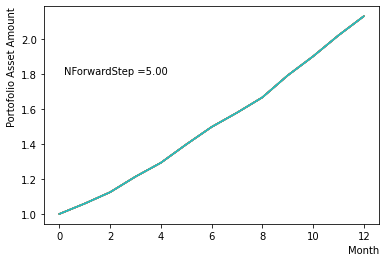

In [54]:
#Create RQA schedule
RQAschedule = []
NReverseStep = 50
TargetS = 0.18
ReverseStep = (1.0 - TargetS) / NReverseStep
MC_step = 20
#Reverse Step
#for i in range(NReverseStep):
for i in range(NReverseStep):
    step_sche = [1.0-i*ReverseStep, 5.0, MC_step]
    RQAschedule.append(step_sche) 
    
#Pause Phase
NPauseStep = 50
step_sche = [TargetS, 5.0, MC_step*NPauseStep]
RQAschedule.append(step_sche) 

#Forward Phase
NForwardStep = 5
ForwardStep = (1.0 - TargetS) / NForwardStep
for i in range(NForwardStep):
    step_sche = [TargetS+(i+1)*ForwardStep, 2.5, MC_step]
    RQAschedule.append(step_sche)

init_state = QA_init_state 

sampleset_RQA_Reverse_Pause_Forward = sampler.sample_qubo(QUBO, schedule=RQAschedule, initial_state = init_state, num_reads=10, reinitialize_state=True) #毎回同じ初期状態からアニーリング
for state in sampleset_RQA_Reverse_Pause_Forward.record:
    selected_charts = list()
    for i in range(Nassets):
        if state[0][i]:
            selected_charts.append(Chart[i])
    portfolioChart = np.mean(selected_charts, axis=0)
    plt.plot(list(range(13)), portfolioChart, label=("Energy="+str(state[1])))

plt.xlabel("Month", loc="right")
plt.ylabel("Portofolio Asset Amount", loc="top")
plt.text(0.2,1.8, "NForwardStep ="+'{:.2f}'.format(NForwardStep))
plt.show()

## 終わりに

OpenJijを用いてReverse Quantum Annealingを実装し、ポートフォリオ最適化問題を解いてみました。このチュートリアルでは、RQAの問題定式化やスケジュール指定のやり方、そしてRQAを行う際に考慮すべきパラメータなどの説明を行いました。RQAの手法を用いることで、正しく最適解を得られることを示しました。

最適解付近にsub-optimalな解が多く存在する他の問題に関しても、同様の手法でより良い解を求めることができます。通常の量子アニーリングで局所解に囚われた場合には、このようにReverse Quantum Annealingを試して見ると解決できるかもしれません。

また、例えばスケジュールの変化が線形関数から非線形な形にした場合の影響など、RQAについてこのチュートリアルで議論しなかった部分もありますが、このチュートリアルにあるコードを変更することそれらを簡単に実行できます。興味がある方は是非試してみてください。


### 付録A シミュレーションの結果が上手くいかない場合
このチュートリアルで使用された銘柄セットの生成コードは、必ずしも構成が「良い」銘柄を生成する保証はありません。そのため、場合によって偏った分布を持ったセットに対して実験する可能性もあります。その時には、遺伝的アルゴリズム計算が非常に長い実行時間になることや、チュートリアルがデフォルトで使用した$s$や$\beta$などのパラメータでRQAが収束しないこともあり得ます。そうした場合は銘柄セットを再生成するか、手動でRQAのパラメータ調整を行って最適解に収束するようにすると良いでしょう。

### 付録B DwaveマシンでRQA実験をする場合のコード
Dwaveマシンにおいてもこのチュートリアルが実行した手法でRQAを実行することができます。ここでは参考としてそのサンプルコードを掲載します。実装及びシミュレーションと実機の違いでスケジュールの設定方法や引数が異なりますが、基本的には同じような過程となります。詳細はDwave公式サイトなどにあるドキュメントを参考にすると良いでしょう。また実機では現実のノイズなどによる影響が見られやすいため、通常のアニーリングとRQAによる結果の違いは見られやすくなります。

In [ ]:
from dwave.system import DWaveSampler, EmbeddingComposite

token = '*** your user token ***'
endpoint = '*** your dwave endpoint***' #'https://cloud.dwavesys.com/sapi/' as defaults

dw_sampler = DWaveSampler(solver='Advantage_system4.1', token=token) #Choose your dwave machine/simulator
sampler = EmbeddingComposite(dw_sampler)

Nassets = 48


# RQA schedule
timing = (0,1,2,3)#各フェーズの開始と終了時刻、フェーズの数を増やしても問題ない
Ratio = (1.0,0.38,0.38,1.0)#各フェーズが変わる時のs
schedule = list(zip(timing,Ratio))#スケジュールにまとめる
plt.plot(timing,Ratio)
plt.show()

#Create QUBO
QUBO = np.random.rand(Nassets**2).reshape(Nassets, Nassets)
for i in  range(Nassets):
    for j in range(Nassets):
        QUBO[i][j] = PairwiseCorrMat[i][j]
for i in range(Nassets):
    QUBO[i][i] = QUBO[i][i] + SR_list[i]

import matplotlib.pyplot as plt
plt.imshow(QUBO)
plt.colorbar()
plt.show()

#FQA
sampleset = sampler.sample_qubo(QUBO,num_reads=10)
print(sampleset.record)

min_forword = 0
for result in sampleset.record:
    if result[1] < min_forword:
        min_forword = result[1]
        best_forword = result[0]
selected_charts = list()
for i in range(Nassets):
    if best_forword[i]:
        selected_charts.append(Chart[i])
portfolioChart_FQA = np.mean(selected_charts, axis=0)
plt.plot(list(range(13)), portfolioChart_FQA,color="r",label="Forward Annealing")

#RQA
sampleset_RQA = sampler.sample_qubo(QUBO,num_reads=10,  anneal_schedule=schedule, initial_state = QA_init_state)
print(sampleset_RQA.record)

min_RQA = 0
for result in sampleset_RQA.record:
    if result[1] < min_RQA:
        min_RQA = result[1]
        best_RQA = result[0]
selected_charts = list()
for i in range(Nassets):
    if best_RQA[i]:
        selected_charts.append(Chart[i])
portfolioChart_RQA = np.mean(selected_charts, axis=0)
plt.plot(list(range(13)), portfolioChart_RQA,color="b",label="Reverse Annealing")
plt.xlabel("Month", loc="right")
plt.ylabel("Portofolio Asset Amount", loc="top")
plt.legend()
plt.show()


## 参考文献
1. Harry Markowitz, "Portfolio selection", The journal of finance, 7(1):77–91 (1952)
2. Davide Venturelli, Alexei Kondratyev, "Reverse Quantum Annealing Approach to Portfolio Optimization Problems", Quantum Machine Intelligence volume 1, pages17–30 (2019)
3. Sharpe, William F., “Mutual fund performance”, The Journal of Business 39 (1), 119-138 (1966)
